In [1]:
import tensorflow as tf


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"
tf_device='/gpu:0'

In [4]:
import pandas as pd
import numpy as np
import os 
import operator
import albumentations as A
import imageio
#import ipyplot
import matplotlib.pyplot as plt
import seaborn as sns
import sys
%matplotlib inline

from PIL import Image

In [5]:
def get_img_id(df): 
    path_mt = []
    path_nu = []
    path_er = [] 
    path_tp = []

    for i, row in df[0:len(df)].iterrows(): 
        img = row.ID
        ids = os.path.basename(img)
        count = row.n_cells
        for i in range(1, count+1):
            path_mt.append(ids+"_"+str(i)+"_mt.png")
            path_nu.append(ids+"_"+str(i)+"_nu.png")
            path_er.append(ids+"_"+str(i)+"_er.png")
            path_tp.append(ids+"_"+str(i)+"_tp.png")
    return path_mt, path_nu, path_er, path_tp


In [6]:
def augment(img_path, img_id_mt, img_id_nu, img_id_er, img_id_tp, times): 
    transform = A.Compose([

        A.Rotate(limit = 90,p=0.5),
        
        A.Transpose(p=0.5),

        A.HorizontalFlip(p=0.5),

        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(p=0.5),

        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5)],

        
        additional_targets = {"image1": "image", "image2": "image", "image3": "image"}, p=1)

    img_mt = imageio.imread(img_path+img_id_mt)
    img_nu = imageio.imread(img_path+img_id_nu)
    img_er = imageio.imread(img_path+img_id_er)
    img_tp = imageio.imread(img_path+img_id_tp)

    transformed = transform(image = img_mt, image1 = img_nu, image2 = img_er, image3 = img_tp)

    transformed_img_mt = transformed["image"]
    transformed_img_nu = transformed["image1"]
    transformed_img_er = transformed["image2"]
    transformed_img_tp = transformed["image3"]

    im_mt = Image.fromarray(transformed_img_mt)
    im_nu = Image.fromarray(transformed_img_nu)
    im_er = Image.fromarray(transformed_img_er)
    im_tp = Image.fromarray(transformed_img_tp)

    im_mt.save("/media/beta/mitko-beps/mandy/aug_train_full/"+"aug_"+ str(times)+"_"+img_id_mt)
    im_nu.save("/media/beta/mitko-beps/mandy/aug_train_full/"+"aug_"+ str(times)+"_"+img_id_nu)
    im_er.save("/media/beta/mitko-beps/mandy/aug_train_full/"+"aug_"+ str(times)+"_"+img_id_er)
    im_tp.save("/media/beta/mitko-beps/mandy/aug_train_full/"+"aug_"+ str(times)+"_"+img_id_tp)
   
    return print("saved aug_"+str(times)+img_id_mt)


## Input

In [7]:
#read in the images and dataframe of segmented cells.
img_path = "../../data/segmented_train/"
df_train_full_segmented = pd.read_csv("/media/beta/mitko-beps/heather/CSV/train_full.csv")
#df_train_full_segmented

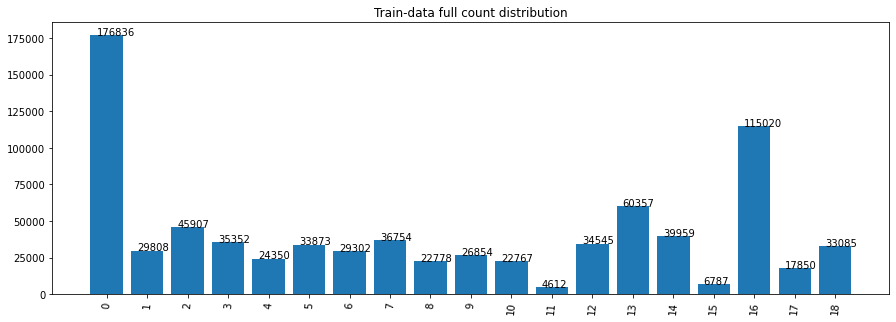

In [8]:
#check the counts
full_counts = {}
labels = [str(i) for i in range(19)]
for lbl in labels:
    count=0
    for i in df_train_full_segmented.index:
        if lbl in df_train_full_segmented['Label'][i].split('|'): 
            count += 1 * df_train_full_segmented['n_cells'][i]
    full_counts[lbl] = count
    
plt.figure(figsize=(15,5))
plt.bar(labels, full_counts.values())

for index, value in enumerate(full_counts.values()):
    plt.text(index-0.25, value, str(value), fontdict=dict(fontsize=10))

plt.title('Train-data full count distribution')
plt.xticks(np.arange(len(labels)), labels, rotation=85)
plt.show()

In [10]:
dict(sorted(full_counts.items(), key=lambda item: item[1]))

{'11': 4612,
 '15': 6787,
 '17': 17850,
 '10': 22767,
 '8': 22778,
 '4': 24350,
 '9': 26854,
 '6': 29302,
 '1': 29808,
 '18': 33085,
 '5': 33873,
 '12': 34545,
 '3': 35352,
 '7': 36754,
 '14': 39959,
 '2': 45907,
 '13': 60357,
 '16': 115020,
 '0': 176836}

In [10]:
#Number of augumentation needed - TEST
import math
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

number_aug = []
for lbl in labels:
    i = int(lbl)
    size_wanted = 30000                         #max aantal per label.
    size_input = list(full_counts.values())[i]  #lengte van wat er al aanwezig is. 
    times = round_down(size_wanted/size_input)  #max_aantal/n_aanwezig
    times = int(times)
    
    number_aug.append(times)
number_aug

[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 6, 0, 0, 0, 4, 0, 1, 0]

In [ ]:
# check dataframe for each label - TEST
number_aug=[]
for lbl in labels:
    lbl_list = []
    lbl_list.append(lbl)
    df_train_full_segmented_lbl = df_train_full_segmented[df_train_full_segmented['Label'].apply(lambda x: pd.Series(x.split('|')).isin(lbl_list).any())]
    path_mt, path_nu, path_er, path_tp = get_img_id(df_train_full_segmented_lbl)
    
    size_wanted = 30000                         #max aantal per label.
    size_input = len(path_mt)  #lengte van wat er al aanwezig is. 
    times = round_down(size_wanted/size_input)  #max_aantal/n_aanwezig
    times = int(times)
    
    number_aug.append(times)
number_aug

## If only labels 11 and 15 would be augmented

In [9]:
wanted_labels11 = ['11'] 
df_wanted_labels11 = df_train_full_segmented[df_train_full_segmented['Label'].apply(lambda x: pd.Series(x.split('|')).isin(wanted_labels11).any())]

wanted_labels_counts11 = {}
for lbl in labels:
    count=0
    for i in df_wanted_labels11.index:
        if lbl in df_wanted_labels11['Label'][i].split('|'): 
            count += 1 * df_wanted_labels11['n_cells'][i] * 5
    wanted_labels_counts11[lbl] = count
    
wanted_labels_counts11

{'0': 6990,
 '1': 0,
 '2': 355,
 '3': 0,
 '4': 0,
 '5': 1195,
 '6': 0,
 '7': 230,
 '8': 0,
 '9': 0,
 '10': 6035,
 '11': 23060,
 '12': 2025,
 '13': 2675,
 '14': 265,
 '15': 0,
 '16': 10840,
 '17': 1340,
 '18': 0}

In [10]:
wanted_labels15 = ['15'] 
df_wanted_labels15 = df_train_full_segmented[df_train_full_segmented['Label'].apply(lambda x: pd.Series(x.split('|')).isin(wanted_labels15).any())]

wanted_labels_counts15 = {}
for lbl in labels:
    count=0
    for i in df_wanted_labels15.index:
        if lbl in df_wanted_labels15['Label'][i].split('|'): 
            count += 1 * df_wanted_labels15['n_cells'][i] * 3
    wanted_labels_counts15[lbl] = count
    
wanted_labels_counts15

{'0': 6582,
 '1': 105,
 '2': 777,
 '3': 261,
 '4': 318,
 '5': 1791,
 '6': 0,
 '7': 426,
 '8': 666,
 '9': 0,
 '10': 0,
 '11': 0,
 '12': 888,
 '13': 996,
 '14': 498,
 '15': 20361,
 '16': 4023,
 '17': 1341,
 '18': 0}

# Augumentation

In [ ]:
"""import math
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier
number_aug = []

for lbl in labels:
    lbl_list = []
    lbl_list.append(lbl)
    df_train_full_segmented_lbl = df_train_full_segmented[df_train_full_segmented['Label'].apply(lambda x: pd.Series(x.split('|')).isin(lbl_list).any())]
    path_mt, path_nu, path_er, path_tp = get_img_id(df_train_full_segmented_lbl)
    
    size_wanted = 30000                         #max aantal per label.
    size_input = len(path_mt)  #lengte van wat er al aanwezig is. 
    times = round_down(size_wanted/size_input)  #max_aantal/n_aanwezig
    times = int(times)
    
    number_aug.append(times)
    for i in range(1,times+1):
        for y in range(len(path_mt)): 
            augment(img_path, path_mt[y], path_nu[y], path_er[y], path_tp[y], i)"""


In [ ]:
#augment label 11
wanted_labels11 = ['11'] 
df_wanted_labels11 = df_train_full_segmented[df_train_full_segmented['Label'].apply(lambda x: pd.Series(x.split('|')).isin(wanted_labels11).any())]
path_mt11, path_nu11, path_er11, path_tp11 = get_img_id(df_wanted_labels11)

n_aug_11 = 6
for i in range(1,n_aug_11+1):
        for y in range(len(path_mt11)): 
            augment(img_path11, path_mt11[y], path_nu11[y], path_er11[y], path_tp11[y], i)



In [11]:
df_f_drop = df_train_full_segmented.copy()
cond = df_f_drop['ID'].isin(df_wanted_labels11['ID'])
df_f_drop.drop(df_f_drop[cond].index, inplace = True)
df_f_drop

,Unnamed: 0,Unnamed: 0.1,ID,Label,n_cells
0,10496,10497,8ac44d34-bbb1-11e8-b2ba-ac1f6b6435d0,14|0,15
1,17020,17021,09e1c1b0-bbc0-11e8-b2bb-ac1f6b6435d0,17,10
2,2361,2361,ece2a9e2-bb9e-11e8-b2b9-ac1f6b6435d0,14|0,12
3,1402,1402,87b625dc-bb9c-11e8-b2b9-ac1f6b6435d0,9,10
4,22854,23708,297_C7_2,6|16,18
...,...,...,...,...,...
23422,21575,21576,61d65b42-bbca-11e8-b2bc-ac1f6b6435d0,5,19
23423,5390,5391,38327d44-bba6-11e8-b2ba-ac1f6b6435d0,16|5,10
23424,860,860,39c9a9ee-bb9b-11e8-b2b9-ac1f6b6435d0,1,12
23425,15795,15796,72c52d32-bbbd-11e8-b2ba-ac1f6b6435d0,16|8,25


In [16]:
#check df_f_drop
print(len(df_train_full_segmented) - len(df_wanted_labels11))

23261


In [ ]:
# augment label 15
wanted_labels15 = ['15'] 
df_wanted_labels15 = df_f_drop[df_f_drop['Label'].apply(lambda x: pd.Series(x.split('|')).isin(wanted_labels15).any())]
path_mt15, path_nu15, path_er15, path_tp15 = get_img_id(df_wanted_labels15)

n_aug_15 = 4
for i in range(1,n_aug_15+1):
        for y in range(len(path_mt15)): 
            augment(img_path15, path_mt15[y], path_nu15[y], path_er15[y], path_tp15[y], i)

In [17]:
print(len(df_wanted_labels15), len(df_wanted_labels11))

272 166


# Make dataframe

In [12]:
#make dataframe
df_wanted_labels11["n_aug"] = int(6)
df_wanted_labels15["n_aug"] = int(4)


df_aug =df_wanted_labels11.append(df_wanted_labels15, ignore_index=True)
df= df_train_full_segmented.merge(df_aug[['ID','n_aug']], on ='ID', how='left')
df['n_aug'] = df['n_aug'].fillna(0).astype(int)
df

<ipython-input-12-52849a76a70b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wanted_labels11["n_aug"] = int(6)
<ipython-input-12-52849a76a70b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wanted_labels15["n_aug"] = int(4)


,Unnamed: 0,Unnamed: 0.1,ID,Label,n_cells,n_aug
0,10496,10497,8ac44d34-bbb1-11e8-b2ba-ac1f6b6435d0,14|0,15,0
1,17020,17021,09e1c1b0-bbc0-11e8-b2bb-ac1f6b6435d0,17,10,0
2,2361,2361,ece2a9e2-bb9e-11e8-b2b9-ac1f6b6435d0,14|0,12,0
3,1402,1402,87b625dc-bb9c-11e8-b2b9-ac1f6b6435d0,9,10,0
4,22854,23708,297_C7_2,6|16,18,0
...,...,...,...,...,...,...
23422,21575,21576,61d65b42-bbca-11e8-b2bc-ac1f6b6435d0,5,19,0
23423,5390,5391,38327d44-bba6-11e8-b2ba-ac1f6b6435d0,16|5,10,0
23424,860,860,39c9a9ee-bb9b-11e8-b2b9-ac1f6b6435d0,1,12,0
23425,15795,15796,72c52d32-bbbd-11e8-b2ba-ac1f6b6435d0,16|8,25,0


In [20]:
df

,Unnamed: 0,Unnamed: 0.1,ID,Label,n_cells,n_aug
0,10496,10497,8ac44d34-bbb1-11e8-b2ba-ac1f6b6435d0,14|0,15,0.0
1,17020,17021,09e1c1b0-bbc0-11e8-b2bb-ac1f6b6435d0,17,10,0.0
2,2361,2361,ece2a9e2-bb9e-11e8-b2b9-ac1f6b6435d0,14|0,12,0.0
3,1402,1402,87b625dc-bb9c-11e8-b2b9-ac1f6b6435d0,9,10,0.0
4,22854,23708,297_C7_2,6|16,18,0.0
...,...,...,...,...,...,...
23422,21575,21576,61d65b42-bbca-11e8-b2bc-ac1f6b6435d0,5,19,0.0
23423,5390,5391,38327d44-bba6-11e8-b2ba-ac1f6b6435d0,16|5,10,0.0
23424,860,860,39c9a9ee-bb9b-11e8-b2b9-ac1f6b6435d0,1,12,0.0
23425,15795,15796,72c52d32-bbbd-11e8-b2ba-ac1f6b6435d0,16|8,25,0.0


In [14]:
df.to_csv("/media/beta/mitko-beps/mandy/train_full_aug.csv")

# --------------------------------------------------------------

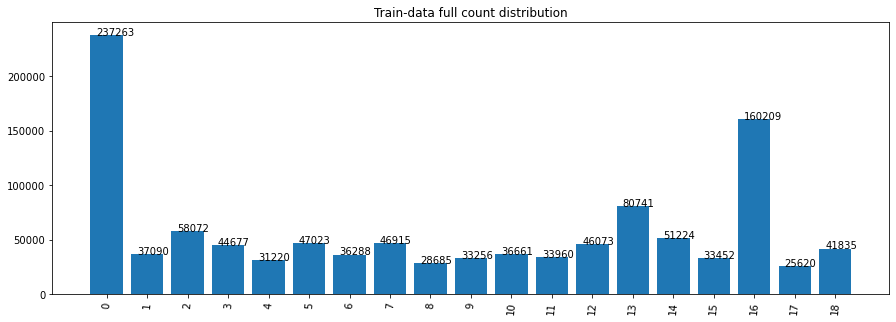

In [49]:
#Total labels from wanted_labels + train labels
total_full_counts = {}
for i in range(0, len(labels)):
    total_full_counts[labels[i]] = list(wanted_labels_counts.values())[i] + list(full_counts.values())[i] + list(wanted_labels_counts11.values())[i] 
total_full_counts

plt.figure(figsize=(15,5))
plt.bar(labels, total_full_counts.values())

for index, value in enumerate(total_full_counts.values()):
    plt.text(index-0.25, value, str(value), fontdict=dict(fontsize=10))

plt.title('Train-data full count distribution')
plt.xticks(np.arange(len(labels)), labels, rotation=85)
plt.show()
